# Generator 구성하기

## 데이터 준비하기

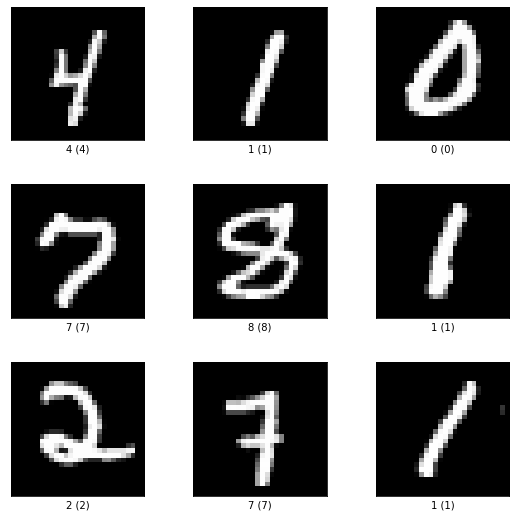

In [1]:
import tensorflow_datasets as tfds

# tensorflow-datasets 라이브러리에서 MNIST dataset 불러오기
mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

In [2]:
import tensorflow as tf

BATCH_SIZE = 128

# 전처리 수행
# 이미지 픽셀 값을 -1~1 사이의 범위로 변경
# 레이블 정보를 원-핫 인코딩 진행

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1 # -1~1 사이의 값으로 바꾸기
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1 # -1~1 사이의 값으로 바꾸기
    
    # label, one-hot encoding
    # 조건부로 y값이 들어가 원하는 값이 나오도록 통제
    label = tf.one_hot(data["label"], 10) 
    
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


Label : tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


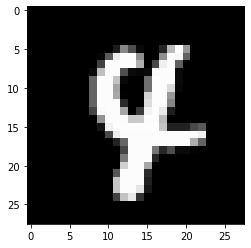

In [3]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

## GAN Generator 구성하기

Tensorflow2의 Subclassing 방법 이용

In [4]:
28 * 28

784

In [5]:
#주석에 맞춰 Generator를 만들어주세요.

from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        # 활성화함수를 'relu'를 사용하고 unit이 128인 Dense Layer를 정의해주세요,.
        self.dense_1 = layers.Dense(128, activation='relu')
        # 활성화함수를 'relu'를 사용하고 unit이 256인 Dense Layer를 정의해주세요.
        self.dense_2 = layers.Dense(256, activation='relu')
        # 활성화함수를 'relu'를 사용하고 unit이 512인 Dense Layer를 정의해주세요.
        self.dense_3 = layers.Dense(512, activation='relu')
        # 활성화함수를 하이퍼볼릭 탄젠트를 사용하고 unit이 756 Dense Layer를 정의해주세요.
        self.dense_4 = layers.Dense(28 * 28 * 1, activation='tanh')
        # 모양일 (28,28,1)로 변경해주세요.
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        
        return self.reshape(out)

print("✅")

✅


## cGAN Generator 구성하기

In [6]:
#주석에 맞춰 Generator를 만들어주세요.

class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        # 노이즈에 Dense layer를 적용시킵니다.
        noise = self.dense_z(noise)
         # 라벨에 Dense layer를 적용시킵니다.
        label = self.dense_y(label)
        
        # 노이즈와 라벨을 pair가 되게 합친 다음 combined_dense를 적용시킵니다. (힌트 : https://www.tensorflow.org/api_docs/python/tf/concat)
        # axis 몇으로 해야되는데?
        out = self.combined_dense(tf.concat([noise, label], axis=1))
        # 마지막 Dense Layer를 적용시킵니다.
        out = self.final_dense(out)

        return self.reshape(out)
    
print("✅")

✅


# Discriminator 구성하기

## GAN Discriminator 구성하기

In [7]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        #해당 방식은 반복문을 활용해 layer를 쌓기 때문에 좋은 테크닉중 하나입니다,.
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


## cGAN Discriminator 구성하기

In [8]:
# MaxOut layer 구성

class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

print("✅")

✅


In [9]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


# 학습 및 테스트하기

## GAN MNIST 학습하기

In [10]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


In [11]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


In [12]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.116481304168701, D:0.14194926619529724
[1/10 EPOCHS, 200 ITER] G:2.3178348541259766, D:0.12158597260713577
[1/10 EPOCHS, 300 ITER] G:2.1912741661071777, D:0.14442548155784607
[1/10 EPOCHS, 400 ITER] G:1.8688222169876099, D:0.32435092329978943
[2/10 EPOCHS, 100 ITER] G:3.557616710662842, D:0.11980300396680832
[2/10 EPOCHS, 200 ITER] G:3.1806344985961914, D:0.31922441720962524
[2/10 EPOCHS, 300 ITER] G:3.5117883682250977, D:0.11573990434408188
[2/10 EPOCHS, 400 ITER] G:4.178857803344727, D:0.10223142802715302
[3/10 EPOCHS, 100 ITER] G:3.4393014907836914, D:0.10124898701906204
[3/10 EPOCHS, 200 ITER] G:3.5233659744262695, D:0.13239070773124695
[3/10 EPOCHS, 300 ITER] G:3.736733913421631, D:0.17765362560749054
[3/10 EPOCHS, 400 ITER] G:3.608433723449707, D:0.08334652334451675
[4/10 EPOCHS, 100 ITER] G:3.561929702758789, D:0.10509666800498962
[4/10 EPOCHS, 200 ITER] G:2.6945695877075195, D:0.1911158263683319
[4/10 EPOCHS, 300 ITER] G:2.6943979263305664, D:0.14150

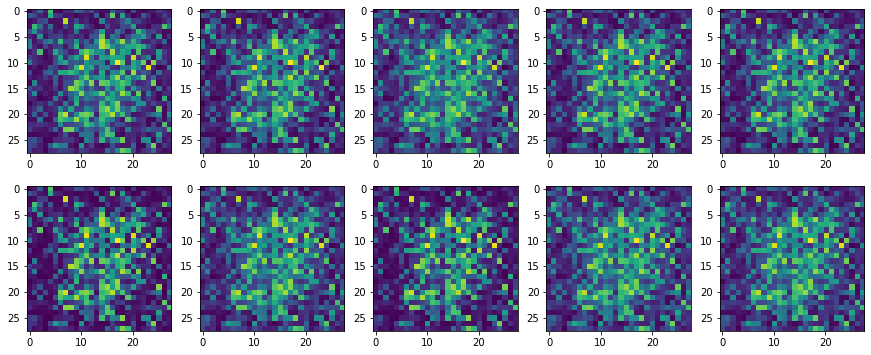

In [13]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

In [ ]:
# $ mkdir -p ~/aiffel/conditional_generation/gan
# $ cp ~/data/gan/GAN_500.zip ~/aiffel/conditional_generation/gan/
# $ cd ~/aiffel/conditional_generation/gan && unzip GAN_500.zip

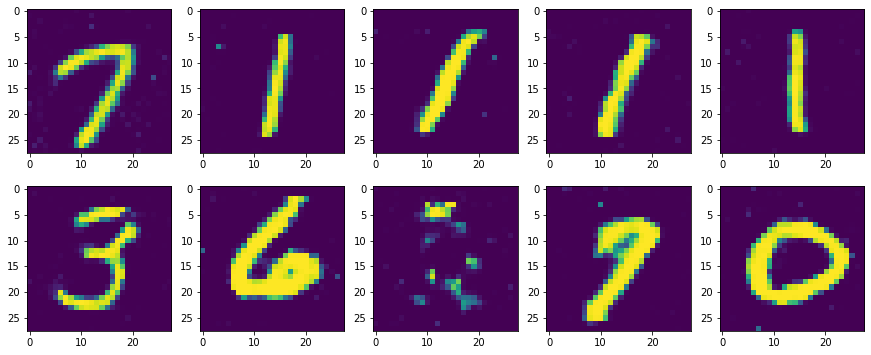

In [14]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

## cGAN으로 MNIST 학습하기 

In [19]:
#위에 있는 gan_step()을 참고해서 cgan_step을 완성해주세요.

cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = gan_generator(noise)
        
        real_out = gan_discriminator(real_images)
        fake_out =  gan_discriminator(fake_images)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    for i, (images, labels) in enumerate(cgan_datasets):    
        gene_loss, disc_loss = cgan_step(images, labels)
        
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:0.00027500666328705847, D:22.68647003173828
[1/1 EPOCHS, 199 ITER] G:0.00020843962556682527, D:23.784366607666016
[1/1 EPOCHS, 299 ITER] G:0.016607852652668953, D:22.83138084411621
[1/1 EPOCHS, 399 ITER] G:0.0007992280297912657, D:22.15705108642578


In [20]:
# $ mkdir -p ~/aiffel/conditional_generation/cgan
# $ cp ~/data/cgan/CGAN_500.zip ~/aiffel/conditional_generation/cgan/
# $ cd ~/aiffel/conditional_generation/cgan && unzip CGAN_500.zip

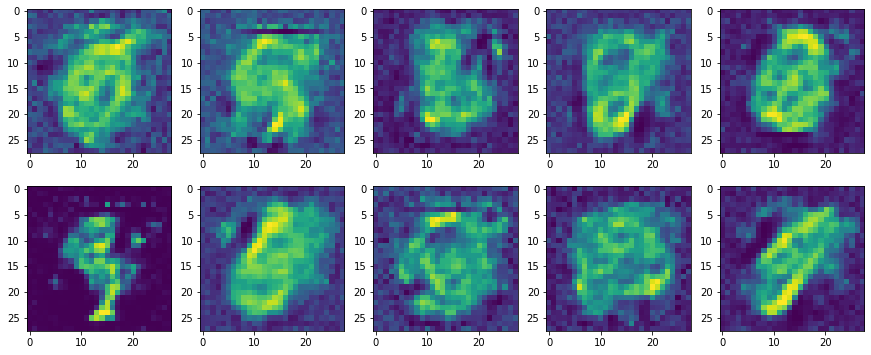

In [25]:
number = 10   # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

# GAN의 입력에 이미지를 넣는다면? Pix2Pix

# 난 스케치를 할 테니 너는 채색을 하거라

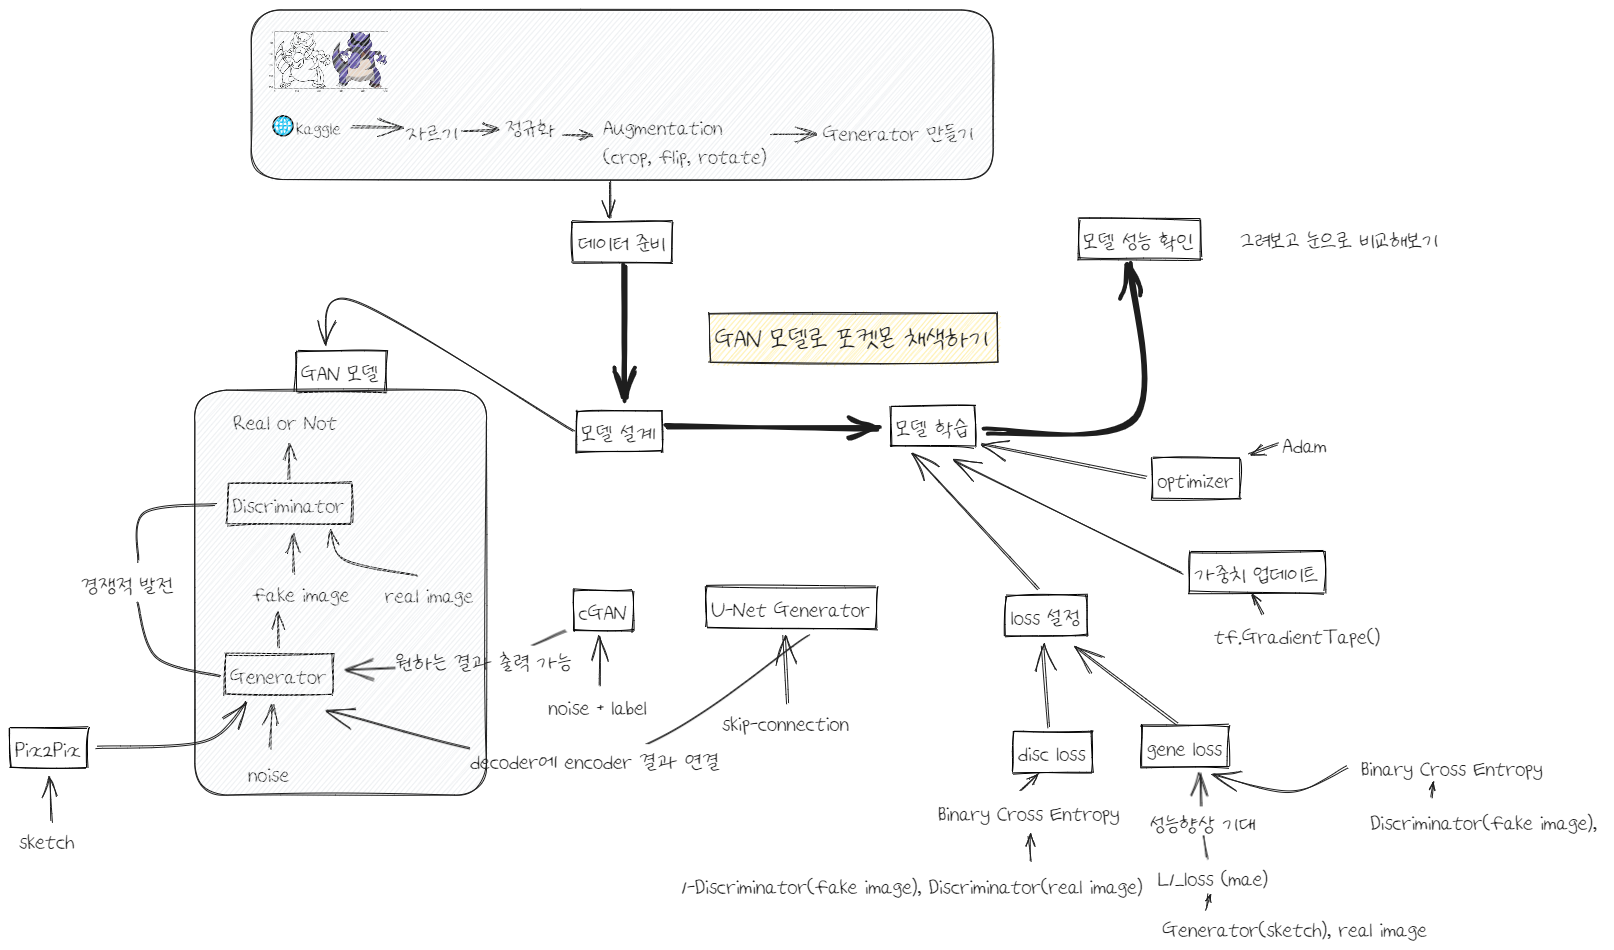

##  (1) 데이터 준비하기

In [26]:
# $ mkdir -p ~/aiffel/conditional_generation/data
# $ ln -s ~/data/sketch2pokemon.zip ~/aiffel/conditional_generation/data
# $ cd ~/aiffel/conditional_generation/data && unzip sketch2pokemon.zip

이번에는 앞서 알아본 pix2pix 모델에 대해서 직접 구현하고 실험해 봅시다.   
사용해 볼 데이터셋은 Sketch2Pokemon이라는 데이터셋입니다.   
https://www.kaggle.com/datasets/norod78/sketch2pokemon   
803개의 이미지   
각 (256x256) 크기의 이미지쌍이 붙어 (256x412) 크기의 이미지로 구성되어있음   

In [28]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


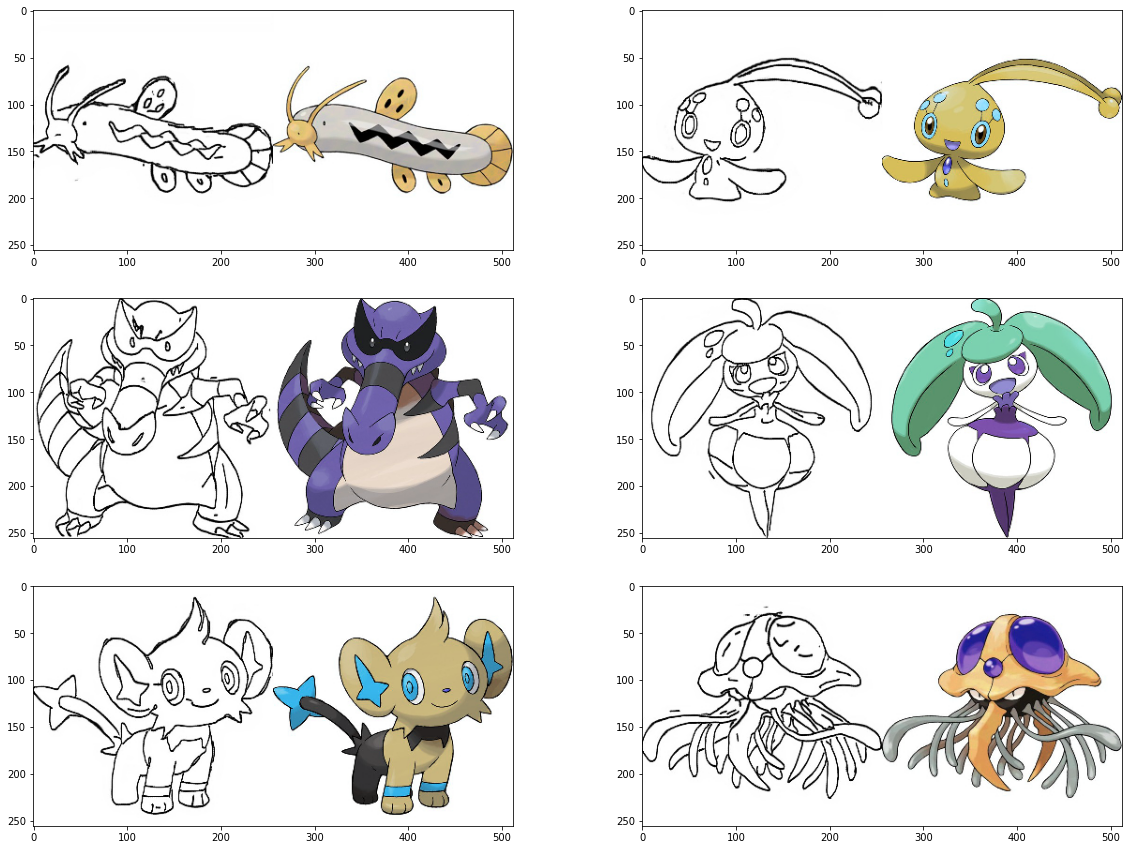

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [30]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


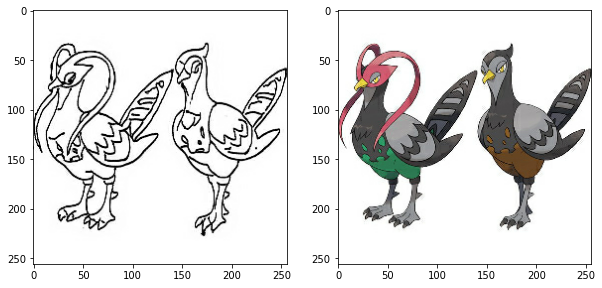

In [31]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [32]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 

# 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
# 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
# 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
# 3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
# 4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
# 5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)

def apply_augmentation(sketch, colored):
    # 두 이미지가 채널 축으로 연결됨
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5: # 50%
        padded = tf.pad(stacked, _pad, "REFLECT") # Refection Padding 적용
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.) # constant padding 적용

    out = image.random_crop(padded, size=[256, 256, 6]) # 임의로 잘라냄
    
    out = image.random_flip_left_right(out) # 50% 확률로 가로로 뒤집음
    out = image.random_flip_up_down(out) # 50% 확률로 세로로 뒤집음
    
    if tf.random.uniform(()) < .5: # 50%
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree) # 회전 시킴
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


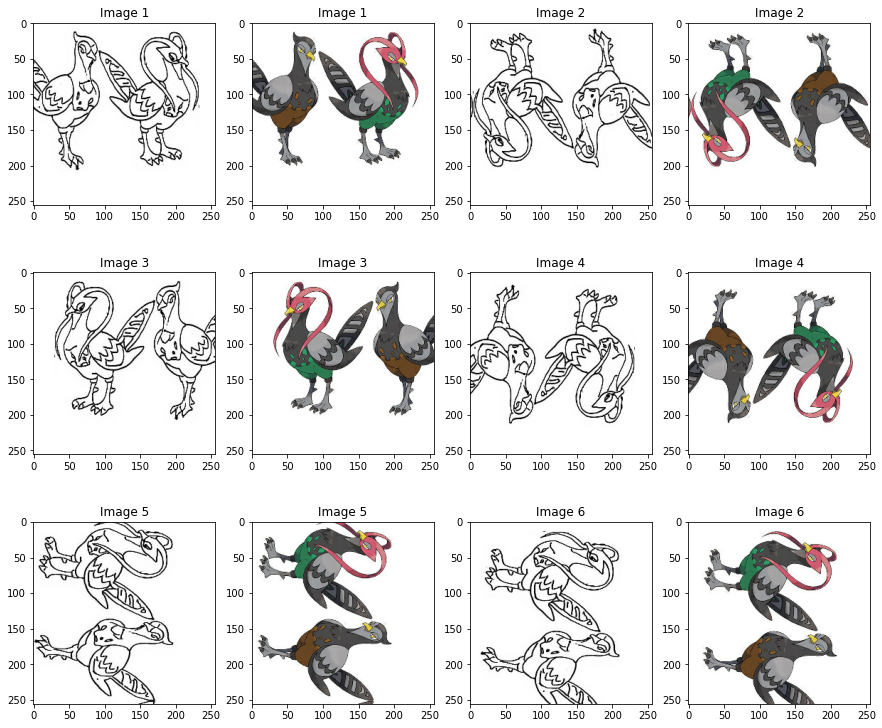

In [33]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

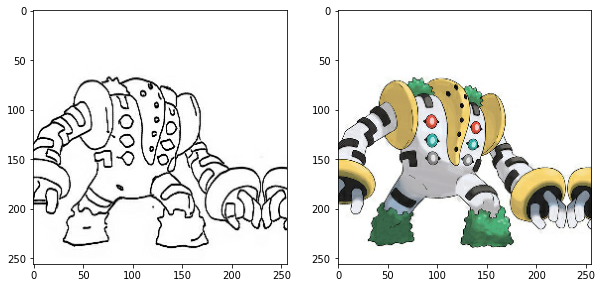

In [34]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## (2) Generator 구성하기

In [35]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [42]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        # for문과 리스트 filter를 활용해서 EncoderBlock을 쌓아주세요.
        # 조건 1. 첫번째 EncoderBlock의 경우 Batch Normalization을 생략해주세요.
        self.blocks = []
        for f in filters:
            self.blocks.append(
                EncodeBlock(f, use_bn=False if f==1 else True)
            )

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [43]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3328      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [47]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        # for문을 이용해서 모델을 쌓아주세요.
        # 조건 1. 3번째 block까지는 Dropout을 사용하되 그 이후에는 Dropout을 사용하지 마세요.
        # for문이 끝난 다음 Conv2DTranspose를 쌓아주되 output 차원수는 3, filter 사이즈는 4, stride는 2로 구성해주시고 자동 패딩 적용해주시되 bias는 사용하지 않습니다.
        self.blocks = []
        for i, f in enumerate(filters):
            self.blocks.append(
                DecodeBlock(f, dropout=True if i < 3 else False)
            )
        self.blocks.append(layers.Conv2DTranspose(filters=3, 
                                                  kernel_size=(4, 4),
                                                  strides=(2, 2), 
                                                  padding='same', 
                                                  use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [48]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [49]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_3 (Encoder)          (None, 1, 1, 512)         19544832  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,616
Trainable params: 39,076,608
Non-trainable params: 11,008
_________________________________________________________________


## (3) Generator 재구성하기

In [50]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        # skip connection을 위해 features라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담는다.
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1] # 마지막 출력은 bottle neck으로 skip connection의 대상이 아님
        
        # Encoder의 최종 출력물이 decoder를 통과할 때 feature와 연결되어 다음 블록의 입력으로 사용됨
        for block, feat in zip(self.decode_blocks, features[::-1]): # 담긴 순서의 반대로 적용해야 됨
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


## (4) Discriminator 구성하기

In [52]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [53]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_30 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [77]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]
        # For문을 활용해서 DiscBlock을 쌓아주세요.
        # 조건 1 : 3번째까지 stride는 2로 주되 이후에는 1로 주세요
        # 조건 2 : 3번째까지 custom padding을 주지 않아도 되는데 이후에는 주세요.
        # 조건 3: 1번째와 5번째에서는 Batch Normalization을 사용하지 마세요.
        # 조건 4 : 1번째부터 4번째까지 LeakyReLU를 적용하고 마지막에는 sigmoid를 적용하세요. (sigmoid의 경우 따로 정의해야 합니다)
        for i, f in enumerate(filters):
            self.blocks.append(DiscBlock(n_filters=f,
                                         stride=2 if i < 3 else 1, 
                                         custom_pad=False if i < 3 else True, 
                                         use_bn=False if i < 5 else True, 
                                         act=True if i < 5 else False))
        self.sigmoid = layers.Activation(activation='sigmoid')
    
    
    def call(self, x, y):
        out = self.blocks[0]([x, y])
        for block in self.blocks[1:]:
            out = block(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [78]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 256, 256, 6)  0           input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
disc_block_35 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_10[0][0]       

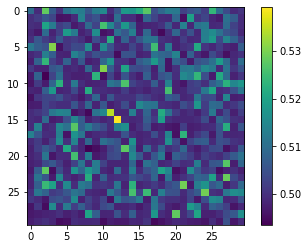

In [79]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## (5) 학습 및 테스트하기

In [80]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    """
    fake_output: 생성한 가짜 이미지
    real_out : 진짜 이미지
    fake_disc : Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값  
    """
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    """
    fake_disc: Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값  
    real_disc: Discriminator에 진짜 이미지를 넣어서 얻은 값
    """
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [81]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [98]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape: # 왜 따로 쓰지?
    # 이전에 배웠던 내용을 토대로 train_step을 구성해주세요.
        fake_images = generator(sketch)
        
        real_disc = discriminator(real_colored, real_colored)
        fake_disc = discriminator(fake_images, real_colored)
        
        gene_loss, l1_loss = get_gene_loss(fake_images, real_colored, fake_disc)
        disc_loss = get_disc_loss(fake_disc, real_disc)
    
    gene_gradient = gene_tape.gradient(gene_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    
    return gene_loss, l1_loss, disc_loss

print("✅")

# l1_loss는 어디에서 쓰인거지?? 요 부분 확인해보자

✅


In [99]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:6.5997                     
L1_loss:6.8383                     
Discriminator_loss:1.7416

EPOCH[1] - STEP[20]                     
Generator_loss:0.7075                     
L1_loss:0.6335                     
Discriminator_loss:0.7406

EPOCH[1] - STEP[30]                     
Generator_loss:1.0613                     
L1_loss:0.9597                     
Discriminator_loss:1.1879

EPOCH[1] - STEP[40]                     
Generator_loss:1.0731                     
L1_loss:0.5142                     
Discriminator_loss:1.1341

EPOCH[1] - STEP[50]                     
Generator_loss:0.1200                     
L1_loss:0.4812                     
Discriminator_loss:9.1851

EPOCH[1] - STEP[60]                     
Generator_loss:1.1350                     
L1_loss:0.6114                     
Discriminator_loss:0.9817

EPOCH[1] - STEP[70]                     
Generator_loss:3.0705                     
L1_loss:0.4629                    

EPOCH[3] - STEP[170]                     
Generator_loss:13.3738                     
L1_loss:0.4257                     
Discriminator_loss:0.2228

EPOCH[3] - STEP[180]                     
Generator_loss:11.7017                     
L1_loss:0.4381                     
Discriminator_loss:0.3206

EPOCH[3] - STEP[190]                     
Generator_loss:10.6319                     
L1_loss:0.5313                     
Discriminator_loss:0.1503

EPOCH[3] - STEP[200]                     
Generator_loss:13.1323                     
L1_loss:0.6965                     
Discriminator_loss:0.1396

EPOCH[4] - STEP[10]                     
Generator_loss:4.2265                     
L1_loss:0.9054                     
Discriminator_loss:0.5123

EPOCH[4] - STEP[20]                     
Generator_loss:9.7946                     
L1_loss:0.4262                     
Discriminator_loss:0.2564

EPOCH[4] - STEP[30]                     
Generator_loss:11.2331                     
L1_loss:0.4151           

EPOCH[6] - STEP[130]                     
Generator_loss:5.6124                     
L1_loss:1.2625                     
Discriminator_loss:0.7283

EPOCH[6] - STEP[140]                     
Generator_loss:6.0982                     
L1_loss:1.4744                     
Discriminator_loss:0.2408

EPOCH[6] - STEP[150]                     
Generator_loss:3.8400                     
L1_loss:2.0816                     
Discriminator_loss:0.2079

EPOCH[6] - STEP[160]                     
Generator_loss:8.2673                     
L1_loss:3.4929                     
Discriminator_loss:0.1004

EPOCH[6] - STEP[170]                     
Generator_loss:10.8776                     
L1_loss:1.4217                     
Discriminator_loss:0.0909

EPOCH[6] - STEP[180]                     
Generator_loss:10.1587                     
L1_loss:1.2508                     
Discriminator_loss:0.0764

EPOCH[6] - STEP[190]                     
Generator_loss:16.9507                     
L1_loss:0.7366          

EPOCH[9] - STEP[90]                     
Generator_loss:36.6238                     
L1_loss:0.6375                     
Discriminator_loss:0.2079

EPOCH[9] - STEP[100]                     
Generator_loss:24.2733                     
L1_loss:0.9357                     
Discriminator_loss:0.1846

EPOCH[9] - STEP[110]                     
Generator_loss:26.3295                     
L1_loss:1.0692                     
Discriminator_loss:0.6342

EPOCH[9] - STEP[120]                     
Generator_loss:19.4390                     
L1_loss:0.9580                     
Discriminator_loss:0.5605

EPOCH[9] - STEP[130]                     
Generator_loss:23.2229                     
L1_loss:1.7783                     
Discriminator_loss:0.3117

EPOCH[9] - STEP[140]                     
Generator_loss:43.5910                     
L1_loss:0.4697                     
Discriminator_loss:0.3216

EPOCH[9] - STEP[150]                     
Generator_loss:38.4244                     
L1_loss:0.4740       

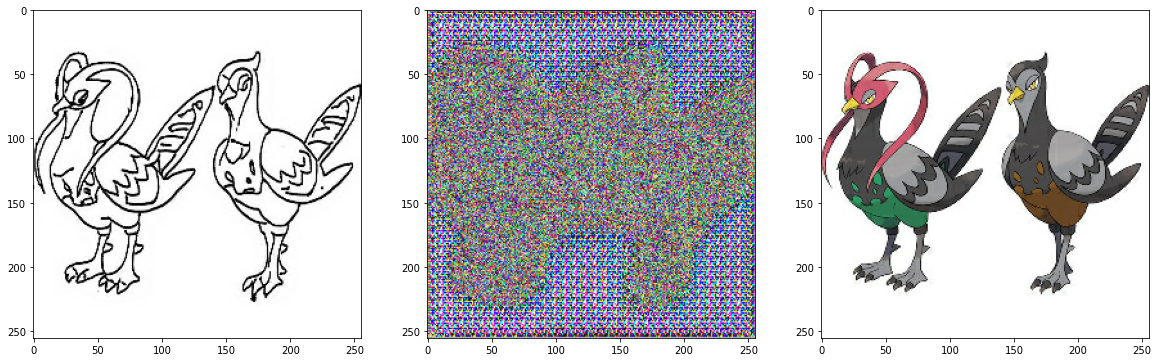

In [100]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

결과 : 아주 엉망이구만...

In [109]:
# 모델 저장하기

generator.save_weights('./generator_weight')

In [113]:
os.listdir('./')

['Study.ipynb',
 '.ipynb_checkpoints',
 'generator_weight.data-00000-of-00001',
 'generator.h5',
 'generator_weight.index',
 'checkpoint']

In [120]:
test = UNetGenerator()

test.load_weights(filepath='./generator_weight')

In [121]:
test.weights

[]